In [1]:
import mat73
data_dict = mat73.loadmat(r"C:\Users\durge\OneDrive\Documents\MATLAB\Kato_et_al\Kato_et_al\ProcData\EEG\KM26_s02\erp_v1.mat")

In [8]:
data_dict['erp'][0,:,0].shape

(2701,)

In [21]:
data_dict['times']

array([-2260.1953125, -2258.1953125, -2256.1953125, ...,  3135.8046875,
        3137.8046875,  3139.8046875])

In [13]:
import numpy as np
arr_2d = np.stack((data_dict['erp'][0,:,0], [1]).reshape(1, -1), axis=1)

ValueError: all input arrays must have the same shape

In [16]:
import mne

info = mne.create_info(ch_names=['Fz'], ch_types=['eeg'] * 1, sfreq=500)
mne_raw = mne.io.RawArray(data_dict['erp'][0,:,0].reshape(1, -1), info)

Creating RawArray with float64 data, n_channels=1, n_times=2701
    Range : 0 ... 2700 =      0.000 ...     5.400 secs
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\durge\AppData\Local\Temp\ipykernel_24552\2061839140.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mne_raw.plot_psd()
C:\Users\durge\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


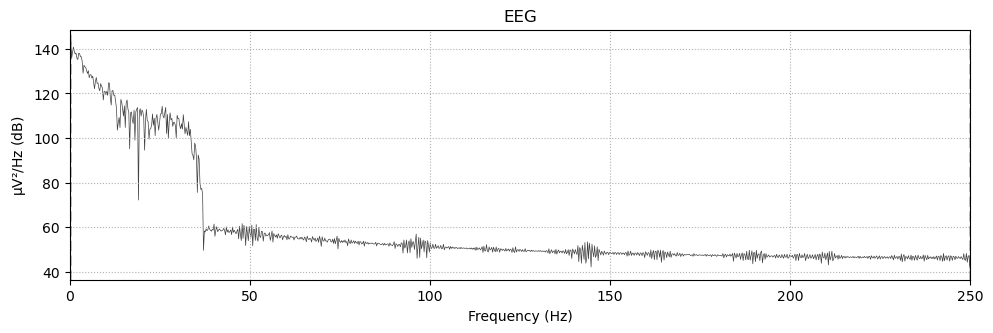

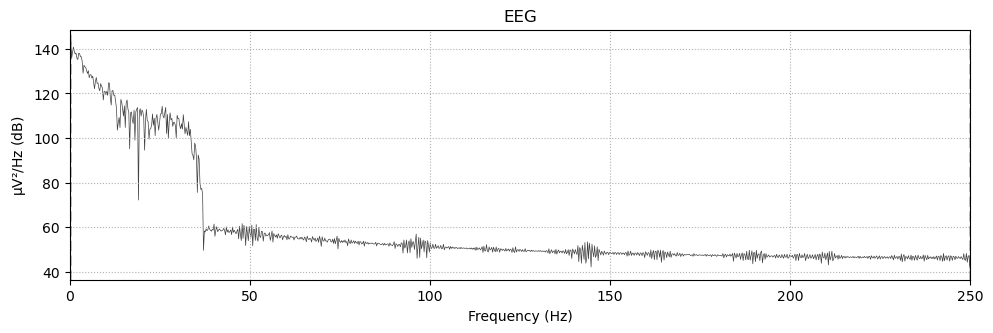

In [18]:
mne_raw.

In [ ]:
import mne

# Step 2: Load raw EEG data
# Replace 'raw_file_path' with the path to your raw EEG data file
raw = mne.io.read_raw('raw_file_path', preload=True)

# Step 3: Preprocessing (optional)
# Perform any preprocessing steps here if needed, such as filtering or artifact removal
# Example:
# raw.filter(0.5, 40)  # Apply bandpass filter between 0.5 Hz and 40 Hz

# Step 4: Create info structure
# Replace the placeholders with your actual channel names and other information
# Example:
info = mne.create_info(ch_names=['Fz', 'Cz', 'Pz', 'Oz'], ch_types=['eeg'] * 4, sfreq=raw.info['sfreq'])

# Step 5: Create MNE object
# Replace 'raw_data' with your actual EEG data and 'info' with your actual info structure
# Example:
# raw_data should be a 2D numpy array with shape (n_channels, n_samples)
# For example, if you have 4 EEG channels and 10000 time points:
# raw_data = your_raw_data_array
mne_raw = mne.io.RawArray(raw.get_data(), info)

# Now, 'mne_raw' is your MNE object containing the EEG data


In [79]:
import mat73
data_dict = mat73.loadmat(r"C:\Users\durge\OneDrive\Documents\MATLAB\Kato_et_al\Kato_et_al\ProcData\EEG\KM26_s02\erp_ave.mat")

In [80]:
data_dict['erp'].shape

(70, 2701, 10)

In [81]:
eeg = data_dict['erp'][0,:,0]

In [82]:
eeg = eeg[1100:1600]

In [83]:
eeg.shape

(500,)

In [60]:
max_time_delay = 10
max_embedding_dimension = 10
stride = 1

if(len(eeg)< max_time_delay * max_embedding_dimension):
    print("Length of EEG sample is ",len(eeg)," and it is less than needed size!!")

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(eeg, max_time_delay, max_embedding_dimension, 
                                                                                      stride=stride)

In [61]:
optimal_embedding_dimension

8

In [62]:
from gtda.plotting import plot_point_cloud

homology_dimensions = [0,1,2,3]
embedding_dimension = 20
embedding_time_delay = 20
stride = 1
STE = SingleTakensEmbedding(
    parameters_type="search", n_jobs=-1, time_delay=optimal_time_delay, dimension=optimal_embedding_dimension, stride=stride
)

y_nonperiodic_embedded = STE.fit_transform(eeg)

In [63]:
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

In [66]:
from gtda.homology import VietorisRipsPersistence

# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
VR = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=-1,
    collapse_edges=True,
)
#persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)
scaling = Scaler()
entropy = PersistenceEntropy(normalize=True, nan_fill_value=-99999999)

diagrams = VR.fit_transform(y_nonperiodic_embedded)

In [69]:
def get_betti_areas(diagrams):
    BC = BettiCurve(n_bins=100)
    bcs= BC.fit_transform(diagrams)
    X = BC.samplings_
    ba_sw =[] # all sliding windows
    i = 0
    for bc in bcs:
        i = i +1
        temp_areas=[]

        for bci,bc_hg in enumerate(bc):
            temp_areas.append(np.trapz(bc_hg,X[bci]))
        ba_sw.append(temp_areas)
    
    return ba_sw

In [70]:
pe=entropy.fit_transform(diagrams)
ba=get_betti_areas(diagrams)

In [72]:
diagrams.shape

(1, 1805, 3)

In [25]:
from sklearn.decomposition import KernelPCA,PCA
from gtda.time_series import TakensEmbedding,SingleTakensEmbedding
from gtda.time_series import Resampler, SlidingWindow, takens_embedding_optimal_parameters, \
    TakensEmbedding, PermutationEntropy, SingleTakensEmbedding
import multiprocessing
from gtda.homology import WeakAlphaPersistence, VietorisRipsPersistence
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance
from gtda.graphs import KNeighborsGraph, GraphGeodesicDistance
from gtda.plotting import plot_diagram
import traceback
import logging
# Import train_test_split function
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

homology_dimensions = [0,1,2,3]
embedding_dimension = 20
embedding_time_delay = 20
stride = 1
STE = SingleTakensEmbedding(
    parameters_type="search", n_jobs=-1, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

# Collapse edges to speed up H2 persistence calculation!
VR = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=-1,
    collapse_edges=True,
)

#persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)
scaling = Scaler()
entropy = PersistenceEntropy(normalize=True, nan_fill_value=-99999)

In [66]:
import matplotlib.pyplot as plt
import numpy as np


# Plot each line separately
for i in range(10):
    plt.plot(data[0, :, i])

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot of Data')
plt.show()

KeyboardInterrupt: 

In [34]:
import numpy as np

np.savetxt('log.csv', data_dict['log'], delimiter=",")

In [31]:
data_dict['times'].shape

(2701,)

In [65]:
import mne
import mne
import os.path as op
import matplotlib 

matplotlib.use('Qt5Agg')

raw1 = mne.io.read_raw_bdf(r"C:\Users\durge\Downloads\Kato_et_al\Kato_et_al\RawData\KM26_s01_01.bdf", preload=True)
raw2 = mne.io.read_raw_bdf(r"C:\Users\durge\Downloads\Kato_et_al\Kato_et_al\RawData\KM26_s01_02.bdf", preload=True)
raw3 = mne.io.read_raw_bdf(r"C:\Users\durge\Downloads\Kato_et_al\Kato_et_al\RawData\KM26_s01_03.bdf", preload=True)

Extracting EDF parameters from C:\Users\durge\Downloads\Kato_et_al\Kato_et_al\RawData\KM26_s01_01.bdf...
BDF file detected


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\durge\\Downloads\\Kato_et_al\\Kato_et_al\\RawData\\KM26_s01_01.bdf'

In [21]:
mne.find_events(raw1)

Trigger channel has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
30 events found
Event IDs: [65282 65283 65286 65287 65289 65290 65296 65297 65301 65302]


array([[  42833,   65280,   65286],
       [  75600,   65280,   65301],
       [ 110824,   65280,   65302],
       [ 143591,   65280,   65297],
       [ 178406,   65280,   65296],
       [ 213221,   65280,   65283],
       [ 247626,   65280,   65287],
       [ 280802,   65280,   65289],
       [ 316436,   65280,   65290],
       [ 352480,   65280,   65282],
       [ 385247,   65280,   65296],
       [ 421290,   65280,   65283],
       [ 455696,   65280,   65289],
       [ 491739,   65280,   65297],
       [ 526555,   65280,   65302],
       [ 560960,   65280,   65286],
       [ 596184,   65280,   65301],
       [ 629770,   65280,   65287],
       [ 666632,   65280,   65282],
       [ 700218,   65280,   65290],
       [ 733804,   65280,   65286],
       [ 766981,   65280,   65283],
       [ 799748,   65280,   65302],
       [ 834153,   65280,   65282],
       [ 868558,   65280,   65289],
       [ 902963,   65280,   65290],
       [ 939826,   65280,   65296],
       [ 973412,   65280,   

In [85]:
raw.drop_channels(['EXG1',
 'EXG2',
 'EXG5',
 'EXG6',
 'EXG7',
 'EXG8'])

<RawEDF | KM32_s01_07.bdf, 67 x 1073152 (524.0 s), ~548.6 MB, data loaded>

In [86]:
raw.set_channel_types({'EXG3':'eog', 'EXG4':'eog'})
# Create the standard montage
montage =  mne.channels.make_standard_montage('biosemi64')

# Set the montage
raw.set_montage(montage)

# Plot the EEG sensor locations
raw.plot_sensors(show_names=True, ch_type='eeg')

<Figure size 640x640 with 1 Axes>

In [88]:
eog_evoked = mne.preprocessing.create_eog_epochs(raw).average()

Using EOG channels: EXG3, EXG4
EOG channel index for this subject is: [64 65]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 118 significant peaks
Number of EOG events detected: 118
Not setting metadata
118 matching events found
No baseline correction applied
Using data from preloaded Raw for 118 events and 2049 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


1 bad epochs dropped


In [89]:
eog_evoked.apply_baseline(baseline=(None, -0.2))

Applying baseline correction (mode: mean)


<Evoked | '998' (average, N=117), -0.5 – 0.5 sec, baseline -0.5 – -0.2 sec, 64 ch, ~1.1 MB>

In [90]:
eog_evoked.plot_joint()

No projector specified for this dataset. Please consider the method self.add_proj.


KeyboardInterrupt: 

In [80]:
eog_evoked = mne.preprocessing.create_eog_epochs(raw)

Using EOG channels: EXG3, EXG4
EOG channel index for this subject is: [64 65]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 118 significant peaks
Number of EOG events detected: 118
Not setting metadata


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


118 matching events found
No baseline correction applied
Using data from preloaded Raw for 118 events and 2049 original time points ...
1 bad epochs dropped


In [91]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 2 EOG, 1 Stimulus
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2020-11-30 10:37:06 UTC
 nchan: 67
 projs: []
 sfreq: 2048.0 Hz
>

In [92]:
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.6s finished


In [95]:
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

ica = ICA(n_components=15, max_iter="auto", random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 15.2s.


Method,fastica
Fit,23 iterations on raw data (1073152 samples)
ICA components,15
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


In [107]:
eog_indices, eog_scores = ica.find_bads_eog(raw)

Using EOG channels: EXG3, EXG4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [108]:
eog_scores

[array([-0.97668606, -0.1133191 , -0.10130177, -0.05521459, -0.10069166,
        -0.03159255, -0.00212436,  0.06884126, -0.01559538,  0.02158217,
         0.00696933, -0.04673255,  0.03089223, -0.05621103,  0.01809282]),
 array([ 0.78602499, -0.12621282,  0.10837316, -0.20509942, -0.28979468,
         0.07374294, -0.05402719,  0.10879908, -0.03053633,  0.09144144,
         0.0871277 , -0.09479912,  0.09540034,  0.04279383,  0.05255771])]

In [109]:
eog_indices

[0]

In [105]:
ica.plot_components()


KeyboardInterrupt



In [103]:
ica.plot_properties(raw, picks=[0, 1])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated


KeyboardInterrupt: 

In [15]:
events = mne.find_events(raw)

Trigger channel has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
30 events found
Event IDs: [65282 65283 65286 65287 65289 65290 65296 65297 65301 65302]


In [13]:
# Step 3: Create epochs
event_id = {'event_name': 65282}  # Define your event IDs
tmin = -0.2  # Define the start time of each epoch (in seconds)
tmax = 1.5  # Define the end time of each epoch (in seconds)
baseline = (None, 0)  # Define baseline correction period (from the beginning of the epoch to time=0)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline, preload=True)

array([[  48881,   65280,   65286],
       [  83286,   65280,   65301],
       [ 116873,   65280,   65283],
       [ 150868,   65280,   65290],
       [ 183635,   65280,   65282],
       [ 220088,   65280,   65297],
       [ 253265,   65280,   65289],
       [ 286442,   65280,   65287],
       [ 320847,   65280,   65296],
       [ 354433,   65280,   65302],
       [ 390477,   65280,   65297],
       [ 424882,   65280,   65289],
       [ 458878,   65280,   65283],
       [ 493283,   65280,   65290],
       [ 526050,   65280,   65287],
       [ 559636,   65280,   65301],
       [ 596499,   65280,   65282],
       [ 630085,   65280,   65296],
       [ 666538,   65280,   65286],
       [ 702582,   65280,   65302],
       [ 739035,   65280,   65289],
       [ 775488,   65280,   65287],
       [ 811122,   65280,   65286],
       [ 845527,   65280,   65297],
       [ 882390,   65280,   65302],
       [ 915976,   65280,   65283],
       [ 950384,   65280,   65282],
       [ 986016,   65280,   

In [ ]:
events_from_annot, event_dict = mne.events_from_annotations(raw)# Get events and event_id from an Annotations object.
event_dict = {'74':74, '75':75, '76':76}                        # Event dictionaries to extract epochs from continuous data, 
reject_criteria = dict(eeg=100e-6)                              # Absolute Amplitude of each epoch sould be smaller than 100 μV
                                                                # tmin is start time before event, tmax is end time after event
                                                                # - 100 ms (baseline) of cue's onset to 600 ms
epochs = mne.Epochs(raw, events_from_annot, event_id=event_dict, tmin=-0.1, tmax=1.6,
                    reject=reject_criteria, baseline = (None,0), preload=True, picks=['eeg'])

In [16]:
ica = mne.preprocessing.ICA(n_components=50, random_state=97, method='fastica')

channels_to_exclude = ['EXG1',
 'EXG2',
 'EXG3',
 'EXG4',
 'EXG5',
 'EXG6',
 'EXG7',
 'EXG8',
 'Status']
raw = raw.drop_channels(channels_to_exclude)

# Create the standard montage
montage =  mne.channels.make_standard_montage('biosemi64')

# Set the montage
raw.set_montage(montage)

# Plot the EEG sensor locations
# raw.plot_sensors(show_names=True, ch_type='eeg')

raw.filter(1, 256)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2.6e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 256.00 Hz
- Upper transition bandwidth: 64.00 Hz (-6 dB cutoff frequency: 288.00 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    4.7s finished


<RawEDF | KM32_s01_07.bdf, 64 x 1073152 (524.0 s), ~524.1 MB, data loaded>

In [17]:
raw_resampled = raw.resample(256)

In [18]:
ica.fit(raw_resampled)   
ica.plot_components()

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 50 components


C:\Users\durge\anaconda3\envs\mne\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 518.9s.


KeyboardInterrupt: 

In [24]:
ica.find_bads_eog(raw, ch_name=['EXG3','EXG4'])

Using EOG channels: EXG3, EXG4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


([0],
 [array([-9.78472645e-01, -5.96359085e-02, -9.31134137e-02,  1.08279847e-01,
         -4.84850505e-02, -3.79487591e-02, -7.96991313e-02, -4.72171387e-02,
          4.66900901e-02, -2.41930983e-03,  5.63509067e-02, -1.91856125e-02,
          2.48671619e-02, -4.92388100e-03, -3.25639463e-02,  3.69322938e-04,
         -8.15880507e-03,  3.69428837e-02, -5.16575457e-03, -1.04981417e-02,
          1.44426294e-03, -1.69557421e-03, -3.05075894e-02,  1.81106756e-02,
          7.13625575e-03, -1.39864504e-02,  3.95735397e-02, -1.92402363e-02,
          5.49973146e-03,  2.60434657e-02, -2.53307802e-03, -2.36105035e-02,
         -9.28458970e-03,  8.84274593e-03,  3.91139681e-02, -1.64539370e-02,
          7.29140172e-03, -2.15600634e-02,  1.46338928e-02,  2.26903828e-02,
          2.76408239e-02,  1.84783357e-02, -3.16927449e-03, -1.13336510e-02,
         -2.79879495e-02,  3.10683571e-02,  1.67246469e-03, -1.97630940e-02,
          2.95000127e-03,  2.57521003e-03]),
  array([ 0.79526962, -0.

In [16]:
events = mne.find_events(raw)

raw.plot(events)

Trigger channel has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
30 events found
Event IDs: [65282 65283 65286 65287 65289 65290 65296 65297 65301 65302]


In [17]:
raw.info['chs'][0]

{'cal': 1.0,
 'logno': 1,
 'scanno': 1,
 'range': 1.0,
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'Fp1',
 'unit': 107 (FIFF_UNIT_V),
 'coord_frame': 4 (FIFFV_COORD_HEAD),
 'coil_type': 1 (FIFFV_COIL_EEG),
 'kind': 2 (FIFFV_EEG_CH),
 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}

In [18]:
raw.plot_sensors(ch_type='eeg')

RuntimeError: No valid channel positions found

In [32]:
# Create the standard montage
montage =  mne.channels.make_standard_montage('biosemi64')

# Set the montage
raw.set_montage(montage)

# Plot the EEG sensor locations
raw.plot_sensors(show_names=True, ch_type='eeg')

<Figure size 640x640 with 1 Axes>

In [ ]:
# List of channels to exclude
exclude_channels = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']

# Pick only EEG channels
eeg_channels = [ch_name for ch_name in raw.ch_names if ch_name not in exclude_channels]

# Create a new raw object with only EEG channels
raw_eeg = raw.copy().pick_channels(eeg_channels)

Waiting for Loading-Thread to finish... (max. 10 sec)
Channels marked as bad:
none
Channels marked as bad:
none


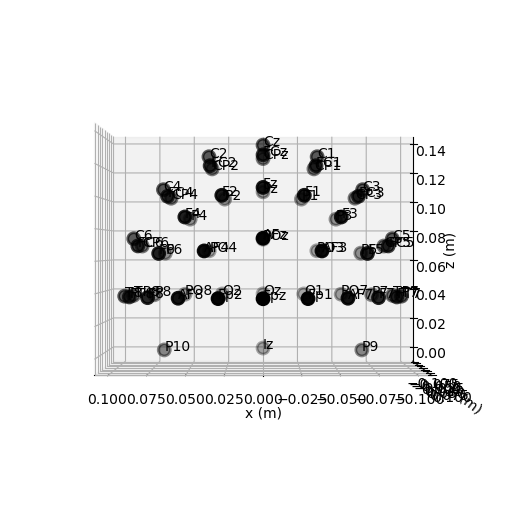

In [54]:
raw_eeg.set_montage(montage)
raw_eeg.plot_sensors(show_names=True, kind='3d')

In [19]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 72 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2020-11-30 10:37:06 UTC
 nchan: 73
 projs: []
 sfreq: 2048.0 Hz
>

In [39]:
import os

import numpy as np

import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(0, 60).load_data()  # just use a fraction of data for speed here

Opening raw data file C:\Users\durge\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.7 MB, data loaded>

In [40]:
ssp_projectors = raw.info["projs"]
raw.del_proj()

<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MB, data loaded>

In [43]:
mag_channels = mne.pick_types(raw.info, meg="mag")
raw.plot(duration=60, order=mag_channels, n_channels=len(mag_channels), remove_dc=False)

In [46]:
raw.plot_psd()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


TypeError: Got unexpected keyword argument title for PSD method "welch".

In [47]:
raw.filter(5,100).plot_psd()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 993 samples (1.653 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 3.410 (s)


[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    0.3s finished


<MNELineFigure size 1000x850 with 6 Axes>

In [1]:
import mne
import numpy as np

# Sample numbers
sample_numbers = np.arange(1, 2702)  # Assuming you have 2701 samples

# EEG data (replace these arrays with your actual data)
data_array = np.random.rand(2701)  # Example random array of EEG data

# Reshape data_array to a 2D array with one channel and 2701 samples
data_2d = data_array.reshape(1, -1)

# Create info structure
info = mne.create_info(ch_names=['EEG'], ch_types=['eeg'], sfreq=1000)  # Adjust sfreq accordingly

# Create MNE object
mne_raw = mne.io.RawArray(data_2d, info)

# Now, 'mne_raw' is your MNE object containing the EEG data

Creating RawArray with float64 data, n_channels=1, n_times=2701
    Range : 0 ... 2700 =      0.000 ...     2.700 secs
Ready.
